In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
BATCH_SIZE = 100
EPOCHS = 15      # Increased slightly to ensure clear latent clusters
LATENT_DIM = 2   # Kept at 2 dimensions for easy visualization (Task 6)
LEARNING_RATE = 1e-3

# Set Device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {DEVICE}")

Computation device: cuda


In [2]:
# Task 1: Dataset Preparation
transform = transforms.Compose([
    transforms.ToTensor(), # Converts images to tensors (0-1 range)
])

# Download and load training and test sets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training data: {len(train_dataset)} samples")
print(f"Testing data: {len(test_dataset)} samples")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]

Training data: 60000 samples
Testing data: 10000 samples


In [3]:
# Task 2: Build the VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()

        # --- Encoder ---
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # We output TWO vectors: Mean (mu) and Log Variance (log_var)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, log_var):
        # The "Reparameterization Trick":
        # z = mu + sigma * epsilon
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) # Random noise
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        # Sigmoid ensures output is between 0 and 1 (like pixel values)
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        recon_batch = self.decode(z)
        return recon_batch, mu, log_var

# Instantiate model
model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model initialized.")

Model initialized.


In [4]:
# Task 3: Define the Loss Function
def loss_function(recon_x, x, mu, log_var):
    # 1. Reconstruction Loss: How well does the output match the input?
    # using Binary Cross Entropy
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. KL Divergence: Distance from a standard normal distribution
    # Formula: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

Starting training...
Epoch [1/15] Average Loss: 187.3550
Epoch [2/15] Average Loss: 166.7044
Epoch [3/15] Average Loss: 162.8882
Epoch [4/15] Average Loss: 160.6139
Epoch [5/15] Average Loss: 158.9362
Epoch [6/15] Average Loss: 157.5473
Epoch [7/15] Average Loss: 156.4647
Epoch [8/15] Average Loss: 155.4507
Epoch [9/15] Average Loss: 154.6885
Epoch [10/15] Average Loss: 153.8912
Epoch [11/15] Average Loss: 153.2598
Epoch [12/15] Average Loss: 152.6503
Epoch [13/15] Average Loss: 152.2023
Epoch [14/15] Average Loss: 151.7845
Epoch [15/15] Average Loss: 151.3168


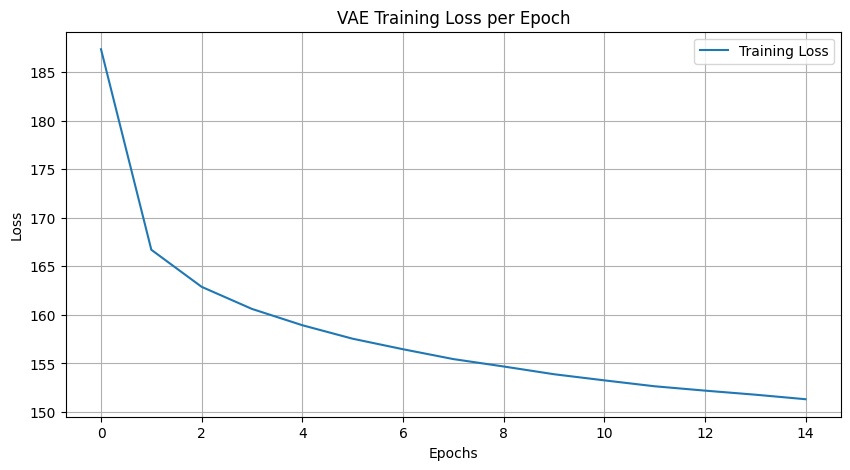

In [5]:
# Task 4: Train the VAE
model.train()
train_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = model(data)

        # Calculate loss
        loss = loss_function(recon_batch, data, mu, log_var)

        # Backward pass and optimization
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    # Log average loss for this epoch
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}')

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title("VAE Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Task 5 & 6: Helper functions for visualization

def visualize_reconstruction(model, loader):
    """Compares original images with their VAE reconstructions"""
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(loader))
        data = data.to(DEVICE)
        recon, _, _ = model(data)

        n = 10  # How many digits to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Display Original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0: ax.set_title("Original")

            # Display Reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0: ax.set_title("Reconstructed")
        plt.show()

def generate_digit(model):
    """Generates a new digit from random noise"""
    model.eval()
    with torch.no_grad():
        # Sample random noise z from Normal(0, 1)
        z = torch.randn(1, LATENT_DIM).to(DEVICE)
        generated_img = model.decode(z).cpu()

        plt.figure(figsize=(4, 4))
        plt.imshow(generated_img.view(28, 28), cmap='gray')
        plt.title("Generated Sample (from noise)")
        plt.axis('off')
        plt.show()

def plot_latent_space(model, loader):
    """Plots the 2D latent space colored by digit class"""
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for data, y in loader:
            data = data.to(DEVICE)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu())
            labels.append(y)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6, s=2)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization (2D)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

=== 1. Reconstruction Quality ===


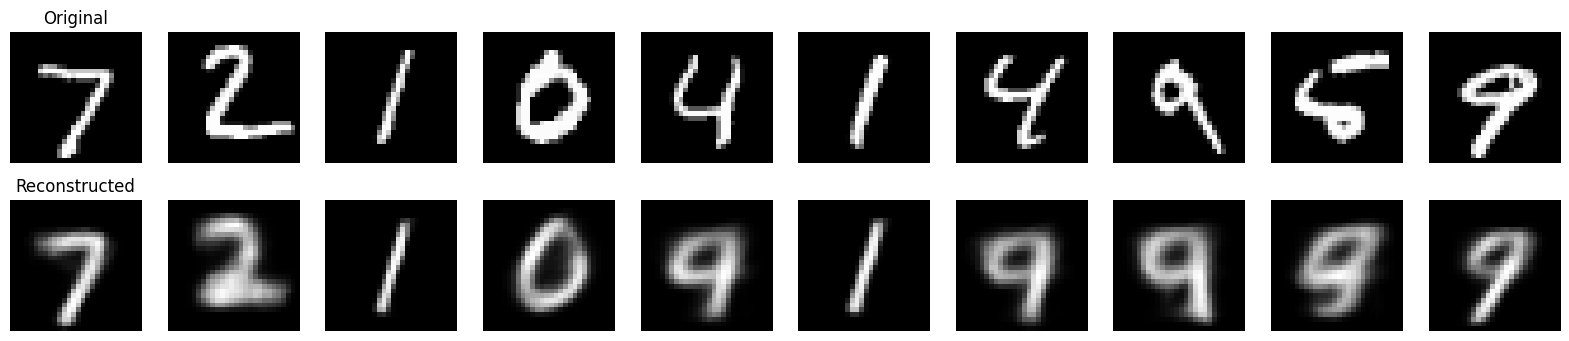


=== 2. Generating New Sample ===


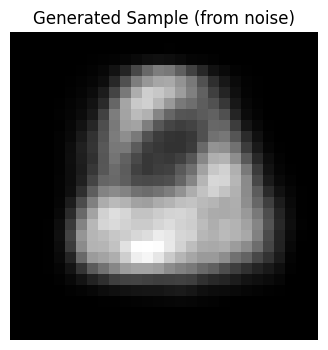


=== 3. Latent Space Map ===


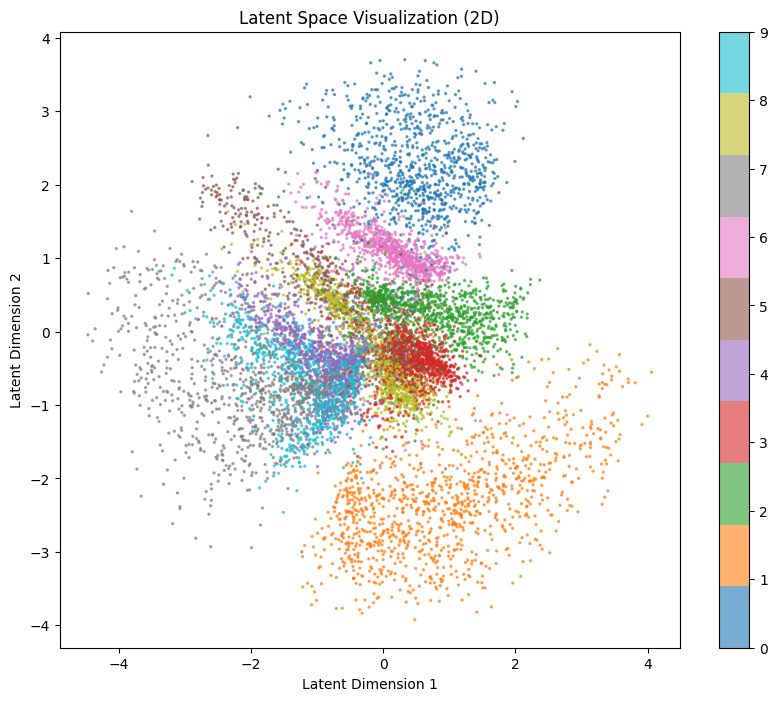

In [8]:
print("=== 1. Reconstruction Quality ===")
visualize_reconstruction(model, test_loader)

print("\n=== 2. Generating New Sample ===")
generate_digit(model)

print("\n=== 3. Latent Space Map ===")
plot_latent_space(model, test_loader)

In [9]:
# 1. Re-initialize the model to start fresh
model_no_kl = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer_no_kl = optim.Adam(model_no_kl.parameters(), lr=1e-3)

# 2. Define Loss WITHOUT KL Divergence
def loss_function_no_kl(recon_x, x, mu, log_var):
    # Only Reconstruction Loss (BCE)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE  # KL Divergence is ignored completely

Starting training (WITHOUT KL Divergence)...
Epoch [1/15] Average Loss: 179.1101
Epoch [2/15] Average Loss: 160.8426
Epoch [3/15] Average Loss: 156.8170
Epoch [4/15] Average Loss: 154.3792
Epoch [5/15] Average Loss: 152.5322
Epoch [6/15] Average Loss: 151.0849
Epoch [7/15] Average Loss: 149.9014
Epoch [8/15] Average Loss: 148.8378
Epoch [9/15] Average Loss: 147.9245
Epoch [10/15] Average Loss: 147.1566
Epoch [11/15] Average Loss: 146.4845
Epoch [12/15] Average Loss: 145.8746
Epoch [13/15] Average Loss: 145.3252
Epoch [14/15] Average Loss: 144.8746
Epoch [15/15] Average Loss: 144.3626


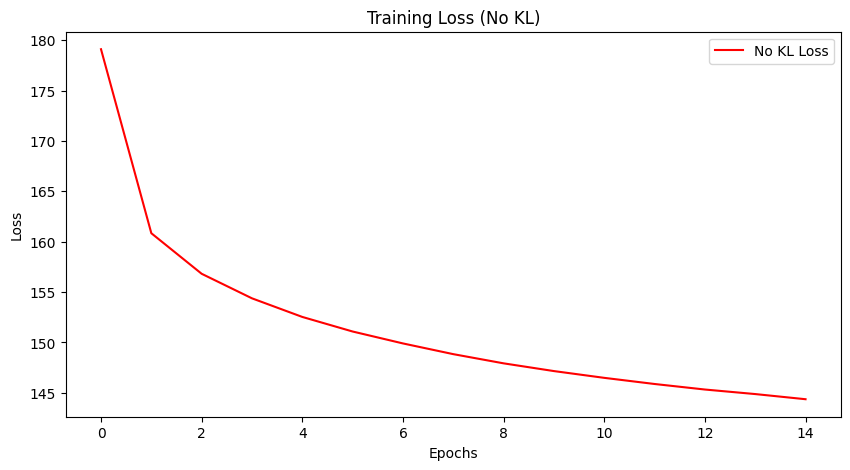

In [10]:
model_no_kl.train()
train_losses_no_kl = []

print("Starting training (WITHOUT KL Divergence)...")

for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)

        optimizer_no_kl.zero_grad()
        recon_batch, mu, log_var = model_no_kl(data)

        # USE THE NEW LOSS FUNCTION
        loss = loss_function_no_kl(recon_batch, data, mu, log_var)

        loss.backward()
        total_loss += loss.item()
        optimizer_no_kl.step()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses_no_kl.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}')

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(train_losses_no_kl, label='No KL Loss', color='red')
plt.title("Training Loss (No KL)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

=== 1. Reconstruction Quality (No KL) ===


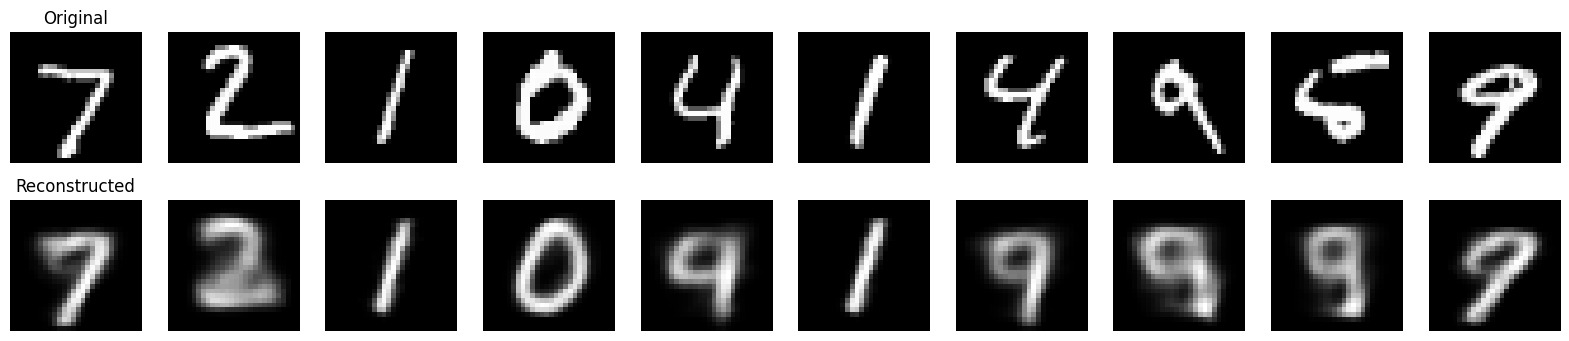


=== 2. Generating New Sample (No KL) ===


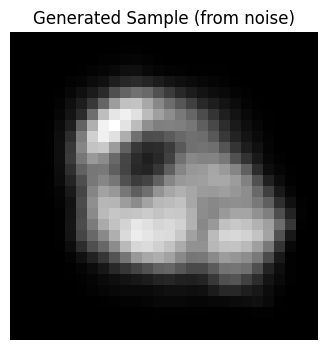


=== 3. Latent Space Map (No KL) ===


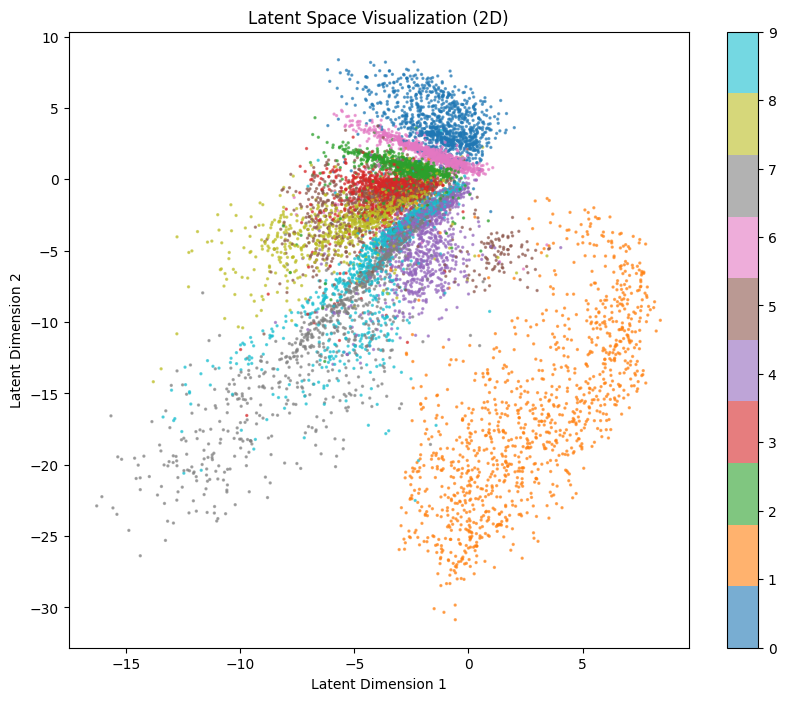

In [11]:
print("=== 1. Reconstruction Quality (No KL) ===")
# It might look slightly sharper than the VAE
visualize_reconstruction(model_no_kl, test_loader)

print("\n=== 2. Generating New Sample (No KL) ===")
# This will likely look like garbage or a random fuzzy blob
generate_digit(model_no_kl)

print("\n=== 3. Latent Space Map (No KL) ===")
# This will likely look "exploded" or not centered at (0,0)
plot_latent_space(model_no_kl, test_loader)